In [3]:
%pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


# Pequeño preprocesado

In [7]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk

# Descargar stopwords si no lo has hecho antes
nltk.download('stopwords')

# Cargamos el dataset
df = pd.read_csv("steam_reseñas.csv")

# Eliminamos reseñas vacías o nulas
df = df[df["review"].notnull()].copy()

# Convertimos a string y minúsculas
df["review"] = df["review"].astype(str).str.lower()

# Stopwords en español (puedes combinar con inglés si lo deseas)
stop_words = set(stopwords.words("spanish"))

# Función de limpieza
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Eliminar números y signos
    text = re.sub(r"[^a-záéíóúüñ\s]", "", text)
    # Eliminar palabras cortas y stopwords
    tokens = text.split()
    tokens = [t for t in tokens if len(t) > 2 and t not in stop_words]
    return " ".join(tokens)

# Aplicamos limpieza
df["clean_review"] = df["review"].apply(clean_text)

# Mostramos una muestra
df[["game_title", "review", "clean_review"]].sample(5)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,game_title,review,clean_review
5536,DOOM Eternal,"muy bueno, el mejor fps que te hará sentir imp...",bueno mejor fps hará sentir imparable diferencia
3070,Stardew Valley,"de los mejores indie que haya jugado, sumament...",mejores indie jugado sumamente entretenido div...
7957,Lords of the Fallen,esta bastante bueno luego de la act.,bastante bueno luego act
5111,Project Zomboid,a cualquiera que le llame la supervivencia har...,cualquiera llame supervivencia hardcoreta tipo...
2165,The Last of Us™ Parte II Remastered,"sinceramente es una obra de arte, sabia del h...",sinceramente obra arte sabia hate woke gusta w...


In [9]:
df.shape

(10534, 7)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Agrupamos todas las reseñas limpias por juego
grouped_reviews = df.groupby("game_title")["clean_review"].apply(lambda x: " ".join(x)).reset_index()

# 2. Vectorizamos las reseñas con TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = vectorizer.fit_transform(grouped_reviews["clean_review"])

# 3. Calculamos la matriz de similitud coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

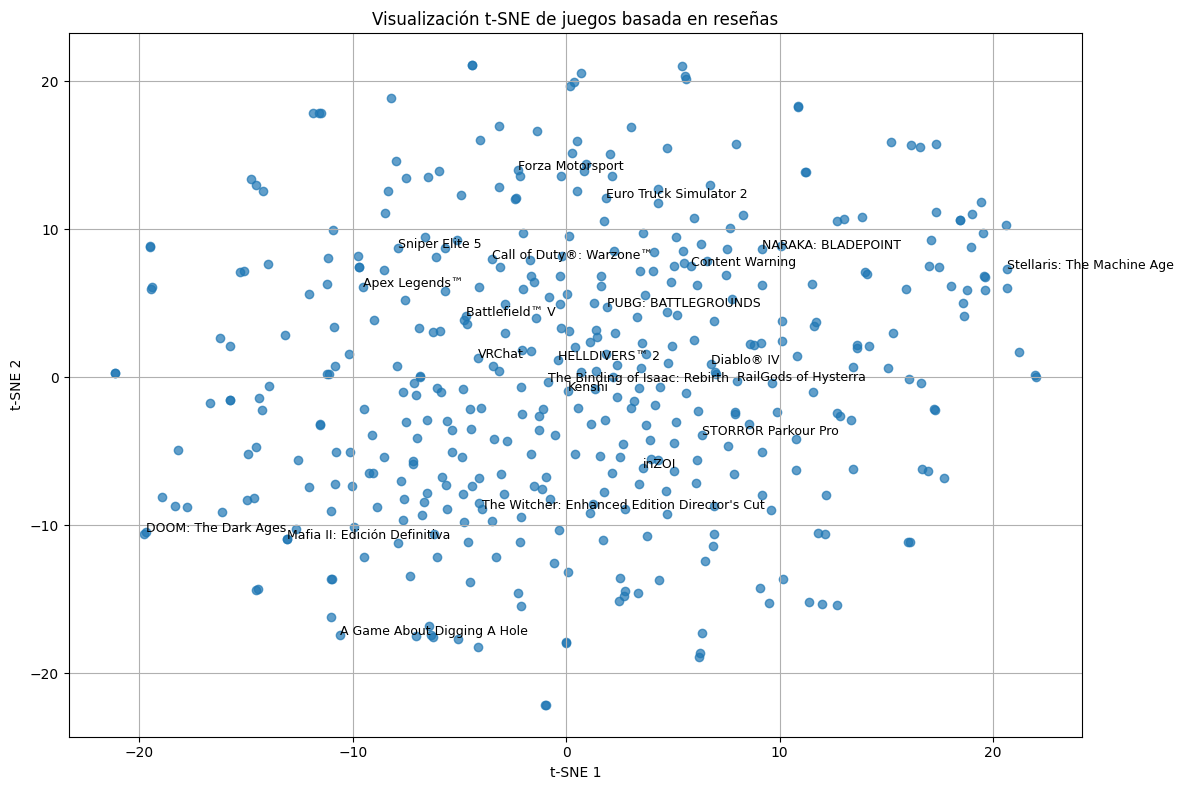

In [11]:
# 4. Reducimos dimensionalidad con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# 5. Visualización
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)

# Anotamos algunos juegos populares
for i, title in enumerate(grouped_reviews["game_title"]):
    if i % 20 == 0:  # Etiquetamos solo algunos para no saturar el gráfico
        plt.text(tsne_results[i, 0], tsne_results[i, 1], title, fontsize=9)

plt.title("Visualización t-SNE de juegos basada en reseñas")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()